In [1]:
#Import knižníc
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
#Nacitanie datasetu
df = pd.read_csv('data/test.csv')

In [3]:
def clean_text(text):
    #Previesť text na malé písmená
    text = text.lower()
    
    #Odstránenie adries URL
    text = re.sub(r'http\S+', '', text)
    
    #Odstránenie hashtagov (iba symbol „#“, text ponechajte)
    text = re.sub(r'#', '', text)
    
    #Odstránenie špeciálnych znakov a čísel
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    
    #Odstránenie zbytočných medzier
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
#Zápis očistených údajov do nového stĺpca
df['clearcontent'] = df['tweet'].apply(clean_text)

In [7]:
#Definovanie hyperparametrov
MAX_LEN = 128
BATCH_SIZE = 16

In [8]:
#Stiahnutie tokenizéra
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
#Vytvorenie triedy pre dátasety
class PredictionDataset(Dataset):
        def __init__(self, data, tokenizer, max_len):
            self.data = data
            self.tokenizer = tokenizer
            self.max_len = max_len
    
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            content = self.data.iloc[idx]['clearcontent']
            
            encoding = self.tokenizer.encode_plus(
                content,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
    
            return {
                'content': content,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()
            }



In [10]:
#Vytváranie datasetov a súborov loadov
prediction_dataset = PredictionDataset(df, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE)

In [11]:
#Definícia zariadenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#Stiahnutie modelu
class BERTClassifier(torch.nn.Module):
    def __init__(self, bert_model, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output

In [13]:
#Načítanie základného modelu BERT
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [14]:
#Inicializácia modelu
model = BERTClassifier(bert_model)
model.load_state_dict(torch.load('best_bert_model.pth'))
model = model.to(device)

In [15]:
#Funkcia pre predikcie
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

In [16]:
#Získavanie predpovedí
predictions = predict(model, prediction_loader, device)

In [34]:
#Pridanie predpovedí do datasetu
df['prediction'] = predictions

In [35]:
#Nahradenie číselných hodnôt zrozumiteľnými popismi
label_mapping = {0: 'fake', 1: 'real'}
df['prediction'] = df['prediction'].map(label_mapping)

In [37]:
#Uloženie výsledkov do nového súboru CSV
df.to_csv('data/test_bert.csv', index=False)

In [38]:
#Nacitanie datasetu
df_test = pd.read_csv('data/test_bert.csv')

In [39]:
#Porovnanie hodnôt v stĺpcoch
df_test['result'] = df_test['label'] == df_test['prediction']

#Počítanie počtu zhody a nezhody
resulttrue = df_test['result'].sum()
resultfalse = len(df_test)-resulttrue

print(f"Počet zápasov: {resulttrue}")
print(f"Počet nezhod: {resultfalse}")

Počet zápasov: 2055
Počet nezhod: 85


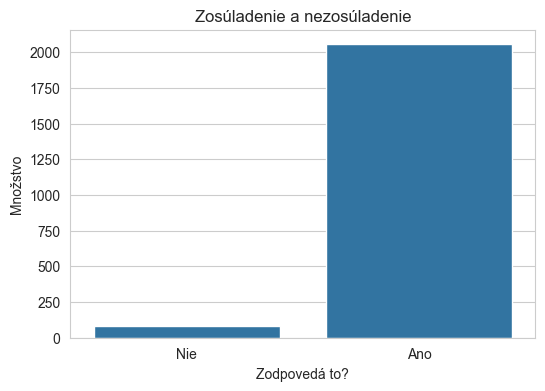

In [40]:
#Vizualizacia počtu zhody a nezhody
plt.figure(figsize=(6, 4))
sns.countplot(x='result', data=df_test)
plt.title('Zosúladenie a nezosúladenie')
plt.xlabel('Zodpovedá to?')
plt.ylabel('Množstvo')
plt.xticks([0, 1], ['Nie', 'Ano'])
plt.show()

In [41]:
#Výpočet kľúčových metrík
accuracy = accuracy_score(df_test['label'], df_test['prediction'])
precision = precision_score(df_test['label'], df_test['prediction'], pos_label='real')
recall = recall_score(df_test['label'], df_test['prediction'], pos_label='real')
f1 = f1_score(df_test['label'], df_test['prediction'], pos_label='real')

#Vytvorenie DataFramu pre metriky
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"]
})
metrics

,Metric,Value
0,Accuracy,0.96
1,Precision,0.98
2,Recall,0.94
3,F1-Score,0.96


In [42]:
# Zobrazenie konfiguracnej tabulky
confusion_matrix = confusion_matrix(df_test['label'], df_test['prediction'], labels=['fake', 'real'])

confusion_matrix = pd.DataFrame(
    confusion_matrix,
    index=['True Fake', 'True Real'],
    columns=['Predicted Fake', 'Predicted Real']
)
confusion_matrix

,Predicted Fake,Predicted Real
True Fake,997,23
True Real,62,1058


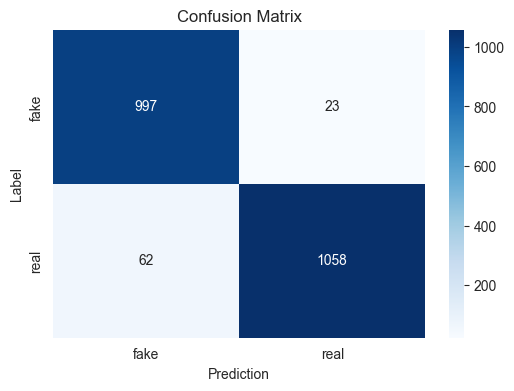

In [43]:
#Vizualizacia konfiguracnej tabulky
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()